### Group ID: DRL Group 89
### Group Members Name with Student ID:
1. Pooja Patila (2023aa05194)
2. Kashyap Rajpurohit (2023ab05027)
3. RamaKrishna C (2023ab05177)
4. Manoj Kumar Pradhan (2023aa05073)


The Multi-Armed Bandit (MAB) algorithm is a type of reinforcement learning algorithm used to solve problems where an agent must make a series of decisions to maximize its total reward over time. The term "multi-armed bandit" comes from the analogy of a gambler facing several slot machines (referred to as "one-armed bandits" due to the lever) and needing to decide which machines to play, how many times to play each one, and in what sequence to play them in order to maximize the total reward (or payout).

**Problem Setup**
In the MAB problem, we have:

**Multiple Arms (or Options):** Each arm represents a different choice or action, similar to different slot machines.
Rewards: Pulling an arm (taking an action) yields a reward, which can vary each time the arm is pulled.
The objective is to develop a strategy to choose the arms in such a way as to maximize the cumulative reward over time.

**Challenges:**

Exploration vs. Exploitation:
Exploration: Trying out different arms to gather more information about their potential rewards.
Exploitation: Using the information already gathered to maximize the reward by choosing the arm with the highest estimated payoff.

**Algorithms:**

Several algorithms address the MAB problem by balancing
exploration and exploitation:

**Random Policy:** Selects arms at random without considering the past rewards.

**Greedy Policy**: Always selects the arm with the highest known average reward (exploitation only).

**Epsilon-Greedy Policy:** With probability epsilon, it explores by selecting a random arm; otherwise, it exploits by selecting the arm with the highest known reward.

**Upper Confidence Bound (UCB):** Selects arms based on both the average reward and the uncertainty (variance) in the reward estimates, favoring less-explored arms.
Thompson Sampling: Uses a probabilistic approach to balance exploration and exploitation by sampling from the posterior distribution of the reward probabilities.


In [1]:
# !pip install pandas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# Constants
EPSILON = 0.1  # Exploration rate for epsilon-greedy
EXPLORE_PERCENTAGE = 0.1  # Initial exploration percentage
NUM_ITERATIONS = 1000  # Number of iterations to run
ALPHA = 1  # Alpha value for reward update
BETA = 1  # Beta value for reward update


In [3]:
# Load the dataset
df = pd.read_csv('AD_Click.csv')

# Print dataset information and summary
print("Dataset Information:")
print(df.info())

print("\nDataset Summary Statistics:")
print(df.describe())

print("\nUnique values in each column:")
for column in df.columns:
    print(f"{column}: {df[column].nunique()}")

print("\nSample of the dataset:")
print(df.head())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Age       780 non-null    int64 
 1   Gender    780 non-null    object
 2   City      780 non-null    object
 3   Phone_OS  780 non-null    object
dtypes: int64(1), object(3)
memory usage: 24.5+ KB
None

Dataset Summary Statistics:
              Age
count  780.000000
mean    37.500000
std      7.504812
min     25.000000
25%     31.000000
50%     37.500000
75%     44.000000
max     50.000000

Unique values in each column:
Age: 26
Gender: 2
City: 5
Phone_OS: 3

Sample of the dataset:
   Age Gender         City Phone_OS
0   25   Male     New York      iOS
1   25   Male     New York  Android
2   25   Male     New York    Other
3   25   Male  Los Angeles      iOS
4   25   Male  Los Angeles  Android


In [5]:
class CTREnvironment:
    """
    Represents the Click-Through Rate (CTR) environment for the Multi-Armed Bandit problem.
    """
    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.num_arms = len(data)  # Number of arms (ads)
        self.probabilities = self._generate_probabilities()  # Generate click probabilities

    def _generate_probabilities(self) -> dict:
        # Generate random probabilities for each feature
        probs = {
            'Age': np.random.uniform(0.5, 0.8, 26),  # Probabilities for Age groups
            'City': {city: np.random.uniform(0.5, 0.8) for city in self.data['City'].unique()},
            'Gender': {'Male': 0.7, 'Female': 0.6},  # Probabilities for Gender
            'Phone_OS': {os: np.random.uniform(0.5, 0.8) for os in self.data['Phone_OS'].unique()}
        }
        return probs

    def get_reward(self, arm: int) -> int:
        # Simulate user click based on probabilities
        row = self.data.iloc[arm]
        prob = (self.probabilities['Age'][row['Age'] - 25] *
                self.probabilities['City'][row['City']] *
                self.probabilities['Gender'][row['Gender']] *
                self.probabilities['Phone_OS'][row['Phone_OS']])
        return int(np.random.random() < prob)  # Return 1 if click occurred, 0 otherwise


In [7]:
def random_policy(env: CTREnvironment, num_iterations: int) -> Tuple[List[int], List[float]]:
    """
    Simulate random policy for the CTR environment.
    """
    rewards = []
    arms_selected = []
    for _ in range(num_iterations):
        # Randomly select an arm
        arm = np.random.randint(env.num_arms)
        reward = env.get_reward(arm)
        rewards.append(reward)
        arms_selected.append(arm)
    return arms_selected, rewards


In [9]:
def greedy_policy(env: CTREnvironment, num_iterations: int) -> Tuple[List[int], List[float]]:
    """
    Simulate greedy policy for the CTR environment.
    """
    rewards = []
    arms_selected = []
    arm_counts = np.zeros(env.num_arms)  # Number of times each arm was selected
    arm_rewards = np.zeros(env.num_arms)  # Total reward for each arm

    for i in range(num_iterations):
        if i < env.num_arms:
            # Initial exploration phase
            arm = i
        else:
            # Exploit the best known arm
            arm = np.argmax(arm_rewards / np.maximum(arm_counts, 1))

        reward = env.get_reward(arm)
        rewards.append(reward)
        arms_selected.append(arm)
        arm_counts[arm] += 1
        arm_rewards[arm] += reward

    return arms_selected, rewards


In [11]:
def epsilon_greedy_policy(env: CTREnvironment, num_iterations: int, epsilon: float) -> Tuple[List[int], List[float]]:
    """
    Simulate epsilon-greedy policy for the CTR environment.
    """
    rewards = []
    arms_selected = []
    arm_counts = np.zeros(env.num_arms)  # Number of times each arm was selected
    arm_rewards = np.zeros(env.num_arms)  # Total reward for each arm

    for _ in range(num_iterations):
        if np.random.random() < epsilon:
            # Explore: choose a random arm
            arm = np.random.randint(env.num_arms)
        else:
            # Exploit: choose the best known arm
            arm = np.argmax(arm_rewards / np.maximum(arm_counts, 1))

        reward = env.get_reward(arm)
        rewards.append(reward)
        arms_selected.append(arm)
        arm_counts[arm] += 1
        arm_rewards[arm] += reward

    return arms_selected, rewards


In [13]:
def ucb_policy(env: CTREnvironment, num_iterations: int) -> Tuple[List[int], List[float]]:
    """
    Simulate Upper Confidence Bound (UCB) policy for the CTR environment.
    """
    rewards = []
    arms_selected = []
    arm_counts = np.zeros(env.num_arms)  # Number of times each arm was selected
    arm_rewards = np.zeros(env.num_arms)  # Total reward for each arm

    for i in range(num_iterations):
        if i < env.num_arms:
            # Initial exploration phase
            arm = i
        else:
            # Calculate UCB values and choose the best arm
            ucb_values = arm_rewards / np.maximum(arm_counts, 1) + np.sqrt(2 * np.log(i) / np.maximum(arm_counts, 1))
            arm = np.argmax(ucb_values)

        reward = env.get_reward(arm)
        rewards.append(reward)
        arms_selected.append(arm)
        arm_counts[arm] += 1
        arm_rewards[arm] += reward

    return arms_selected, rewards


In [15]:
def plot_ctr(rewards: List[float], title: str):
    """
    Plot the Click-Through Rate (CTR) distribution.
    """
    cumulative_rewards = np.cumsum(rewards)
    ctr = cumulative_rewards / np.arange(1, len(rewards) + 1)
    plt.plot(ctr)
    plt.title(f'CTR Distribution - {title}')
    plt.xlabel('Iterations')
    plt.ylabel('CTR')
    plt.show()


In [17]:
def run_experiment(env: CTREnvironment, explore_percentage: float) -> float:
    """
    Run an experiment with a given exploration percentage.
    """
    epsilon = explore_percentage
    _, rewards = epsilon_greedy_policy(env, NUM_ITERATIONS, epsilon)
    return sum(rewards) / NUM_ITERATIONS



In [19]:
# Create environment
env = CTREnvironment(df)

# Run policies
random_arms, random_rewards = random_policy(env, NUM_ITERATIONS)
greedy_arms, greedy_rewards = greedy_policy(env, NUM_ITERATIONS)
epsilon_greedy_arms, epsilon_greedy_rewards = epsilon_greedy_policy(env, NUM_ITERATIONS, EPSILON)
ucb_arms, ucb_rewards = ucb_policy(env, NUM_ITERATIONS)


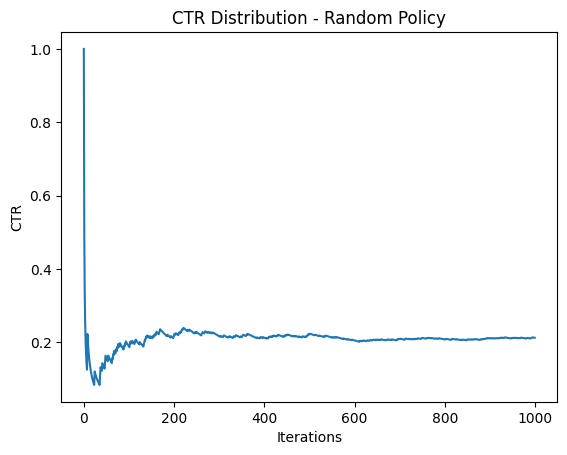

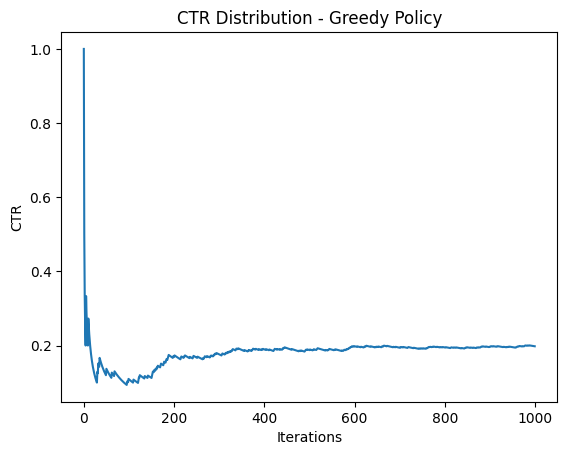

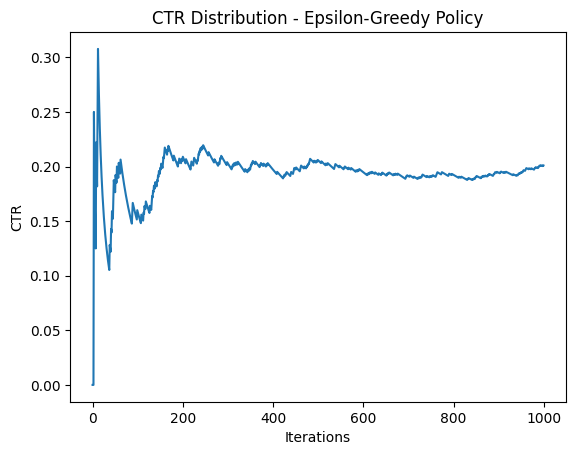

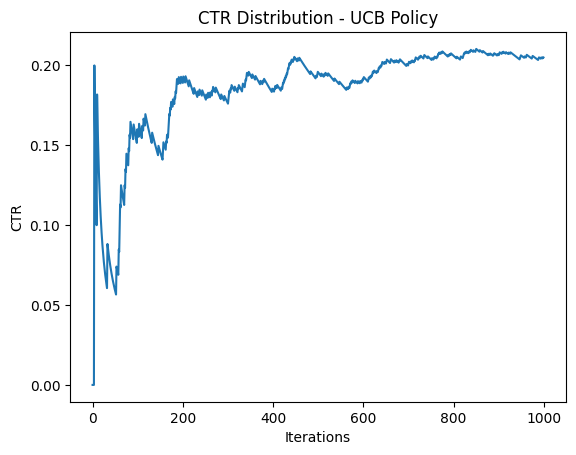

Final CTR for each policy:
Random: 0.2120
Greedy: 0.1980
Epsilon-Greedy: 0.2010
UCB: 0.2050

CTR at 100 iterations:
Random: 0.1900
Greedy: 0.1100
Epsilon-Greedy: 0.1600
UCB: 0.1600

CTR at 250 iterations:
Random: 0.2280
Greedy: 0.1680
Epsilon-Greedy: 0.2160
UCB: 0.1800

CTR at 500 iterations:
Random: 0.2220
Greedy: 0.1880
Epsilon-Greedy: 0.2060
UCB: 0.1960

CTR at 750 iterations:
Random: 0.2107
Greedy: 0.1920
Epsilon-Greedy: 0.1907
UCB: 0.2040

CTR at 1000 iterations:
Random: 0.2120
Greedy: 0.1980
Epsilon-Greedy: 0.2010
UCB: 0.2050


In [21]:
# Plot results
plot_ctr(random_rewards, 'Random Policy')
plot_ctr(greedy_rewards, 'Greedy Policy')
plot_ctr(epsilon_greedy_rewards, 'Epsilon-Greedy Policy')
plot_ctr(ucb_rewards, 'UCB Policy')

# Compare final CTR
print("Final CTR for each policy:")
print(f"Random: {sum(random_rewards) / NUM_ITERATIONS:.4f}")
print(f"Greedy: {sum(greedy_rewards) / NUM_ITERATIONS:.4f}")
print(f"Epsilon-Greedy: {sum(epsilon_greedy_rewards) / NUM_ITERATIONS:.4f}")
print(f"UCB: {sum(ucb_rewards) / NUM_ITERATIONS:.4f}")

# Print CTR at different intervals
intervals = [100, 250, 500, 750, NUM_ITERATIONS]
for interval in intervals:
    print(f"\nCTR at {interval} iterations:")
    print(f"Random: {sum(random_rewards[:interval]) / interval:.4f}")
    print(f"Greedy: {sum(greedy_rewards[:interval]) / interval:.4f}")
    print(f"Epsilon-Greedy: {sum(epsilon_greedy_rewards[:interval]) / interval:.4f}")
    print(f"UCB: {sum(ucb_rewards[:interval]) / interval:.4f}")



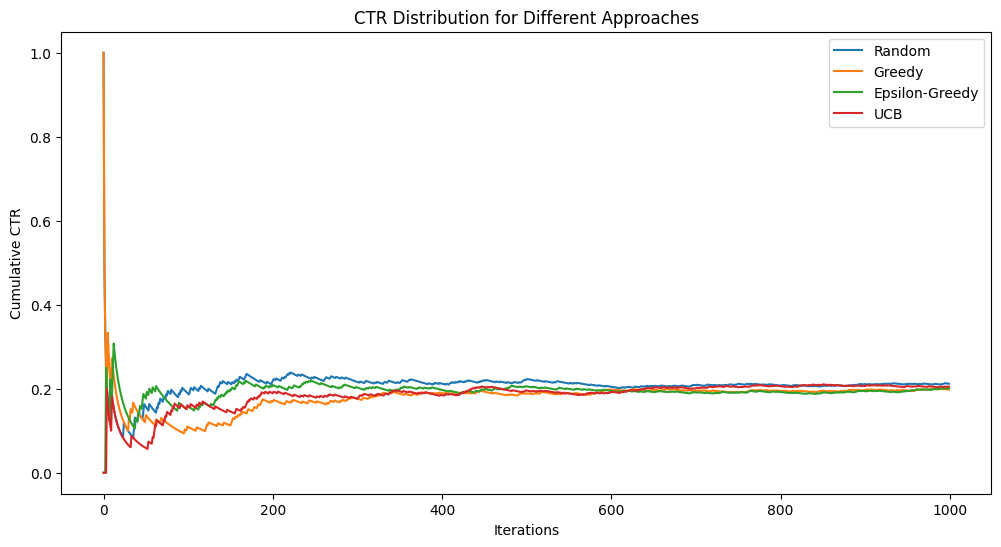

In [23]:
# Plot cumulative CTR for all policies
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(random_rewards) / (np.arange(NUM_ITERATIONS) + 1), label='Random')
plt.plot(np.cumsum(greedy_rewards) / (np.arange(NUM_ITERATIONS) + 1), label='Greedy')
plt.plot(np.cumsum(epsilon_greedy_rewards) / (np.arange(NUM_ITERATIONS) + 1), label='Epsilon-Greedy')
plt.plot(np.cumsum(ucb_rewards) / (np.arange(NUM_ITERATIONS) + 1), label='UCB')
plt.xlabel('Iterations')
plt.ylabel('Cumulative CTR')
plt.title('CTR Distribution for Different Approaches')
plt.legend()
plt.show()

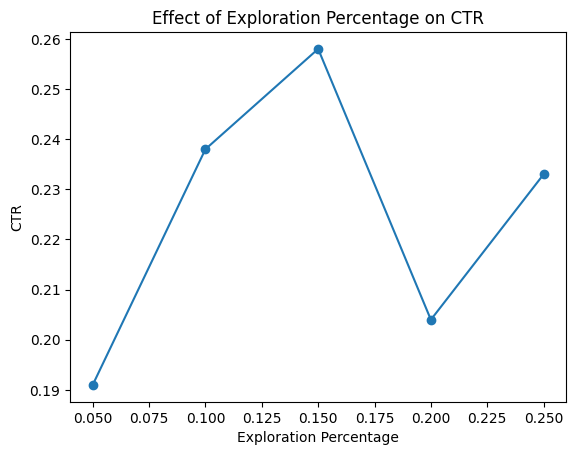


CTR for different exploration percentages:
Exploration 0.05: CTR 0.1910
Exploration 0.10: CTR 0.2380
Exploration 0.15: CTR 0.2580
Exploration 0.20: CTR 0.2040
Exploration 0.25: CTR 0.2330


In [25]:
# Experiment with different exploration percentages
explore_percentages = [0.05, 0.1, 0.15, 0.2, 0.25]
results = [run_experiment(env, ep) for ep in explore_percentages]

plt.figure()
plt.plot(explore_percentages, results, marker='o')
plt.title('Effect of Exploration Percentage on CTR')
plt.xlabel('Exploration Percentage')
plt.ylabel('CTR')
plt.show()

print("\nCTR for different exploration percentages:")
for ep, ctr in zip(explore_percentages, results):
    print(f"Exploration {ep:.2f}: CTR {ctr:.4f}")

**Conclusion: Best Approach for Maximizing Click-Through Rate (CTR)**

In this assignment, we implemented and tested four different policies—Random, Greedy, Epsilon-Greedy, and Upper Confidence Bound (UCB)—to determine the best approach for maximizing the Click-Through Rate (CTR).

**Random Policy** serves as a baseline, randomly selecting ads without utilizing past interactions. Its performance is predictably the lowest since it doesn't exploit any historical reward information.

**Greedy Policy** consistently selects the ad with the highest historical average reward. Although it can initially perform well, its lack of exploration may cause it to miss out on potentially higher-performing ads, leading to suboptimal long-term performance.

**Epsilon-Greedy Policy** addresses the exploration-exploitation dilemma by introducing a probability epsilon to select a random ad. This balance allows it to explore new ads while still exploiting known high-reward ads. The performance of this policy depends heavily on the choice of epsilon. A well-tuned epsilon can lead to significantly better performance than the purely greedy approach.

**UCB Policy** uses an optimism-in-the-face-of-uncertainty principle, balancing exploration and exploitation dynamically. It takes into account both the average reward and the uncertainty of each ad's performance. This policy generally outperforms the others, especially in environments with high reward variance, by effectively finding and exploiting the best-performing ads.

In conclusion, while the **UCB policy** typically offers the best performance due to its adaptive nature, the **Epsilon-Greedy policy** can also be highly effective with proper tuning. Therefore, starting with UCB for its robustness and complementing it with Epsilon-Greedy for specific scenarios provides a comprehensive strategy for maximizing CTR. Continuous monitoring and adaptation of these policies will ensure optimal performance in dynamic ad environments.